In [95]:
%pylab inline
import os.path as op
import sys
import os

import json
import skimage.color
import skimage.filters
import morphsnakes as ms
import io3d.datasets


Populating the interactive namespace from numpy and matplotlib


In [96]:
pth = op.abspath("..")
sys.path.insert(0, pth)
import scaffan
import scaffan.annotation
import scaffan.image as scim
scaffan.image.import_openslide()

In [97]:
pth = op.expanduser(r"~\Downloads\openslide\openslide-win64\bin")
# pth = op.expanduser(r"~\projects\scaffan\devel\knihovny")
# pth = op.expanduser(r"~\Miniconda3\envs\lisa36\Library\bin")
sys.path.insert(0, pth)
orig_PATH = os.environ["PATH"]
os.environ["PATH"] = pth + ";" + os.environ["PATH"]
import openslide as opsl

In [117]:
import scaffan.annotation as scan
slices_dir = io3d.datasets.join_path("scaffold/Hamamatsu", get_root=True)
datapath = r"e:data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
annotation = scan.read_annotations(datapath)

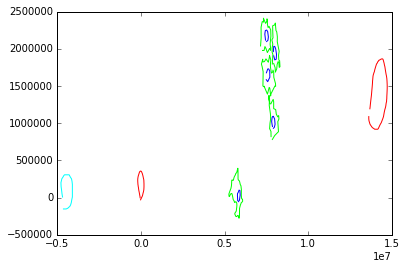

In [118]:
scan.plot_annotations(annotation)

size [ 820.594  671.498]
size [ 849.419  542.652]
size [ 618.869  461.659]
size [ 481.337  660.092]
size [ 623.227  593.58 ]
size [ 187.395  182.867]
size [ 211.118  154.366]
size [ 211.115  170.991]
size [ 204.006  161.492]
size [ 163.723  155.014]
size [ 1100.958   945.465]
size [ 373.49   386.498]


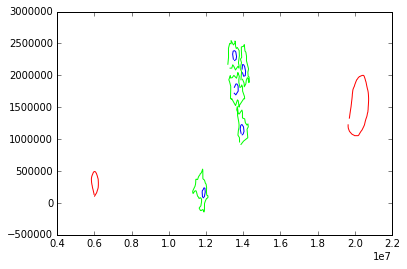

In [100]:
originx = 6028294
originy = 135608

def plot_annotations(annotations):
    for annotation in annotations:
        x = np.asarray(annotation["x"])
        y = np.asarray(annotation["y"])
        plt.hold(True)
        plt.plot(x + originx , y + originy, c=annotation["color"])
        size_mm = np.asarray([np.max(x) - np.min(x), np.max(y) - np.min(y)]) * 0.001
        print("size", size_mm)
plot_annotations(annotation)

size [ 820.594  671.498]
size [ 849.419  542.652]
size [ 618.869  461.659]
size [ 481.337  660.092]
size [ 623.227  593.58 ]
size [ 187.395  182.867]
size [ 211.118  154.366]
size [ 211.115  170.991]
size [ 204.006  161.492]
size [ 163.723  155.014]
size [ 1100.958   945.465]
size [ 373.49   386.498]


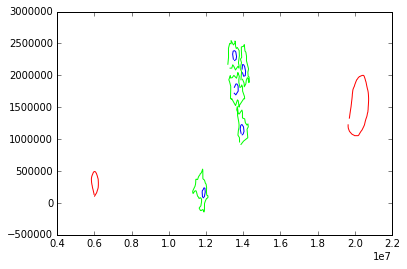

In [101]:
plot_annotations(annotation)

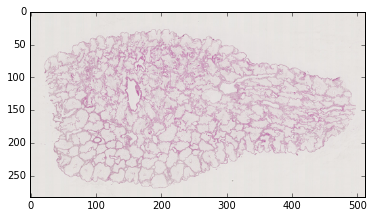

In [102]:
pth = r"E:/data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
imsl = opsl.OpenSlide(pth)
imthumb = imsl.get_thumbnail((512, 512))

plt.imshow(imthumb)

In [103]:
pm = imsl.properties
list(pm.keys())

['hamamatsu.AHEX[0]',
 'hamamatsu.AHEX[0].fluorescence',
 'hamamatsu.AHEX[0].ploidy',
 'hamamatsu.AHEX[1]',
 'hamamatsu.AHEX[1].fluorescence',
 'hamamatsu.AHEX[1].ploidy',
 'hamamatsu.AHEX[2]',
 'hamamatsu.AHEX[2].fluorescence',
 'hamamatsu.AHEX[2].ploidy',
 'hamamatsu.Created',
 'hamamatsu.MHLN[0].24bit',
 'hamamatsu.MHLN[0].36bit',
 'hamamatsu.MHLN[1].24bit',
 'hamamatsu.MHLN[1].36bit',
 'hamamatsu.MHLN[2].24bit',
 'hamamatsu.MHLN[2].36bit',
 'hamamatsu.Macro.S/N',
 'hamamatsu.NDP.S/N',
 'hamamatsu.Objective.Lens.Magnificant',
 'hamamatsu.PSHV',
 'hamamatsu.PSHV.10x',
 'hamamatsu.PSHV.40x',
 'hamamatsu.PSHV.ploidy',
 'hamamatsu.PSHV.ploidy.10x',
 'hamamatsu.Product',
 'hamamatsu.Reference',
 'hamamatsu.SourceLens',
 'hamamatsu.Updated',
 'hamamatsu.XOffsetFromSlideCentre',
 'hamamatsu.YOffsetFromSlideCentre',
 'hamamatsu.YRNP[0]',
 'hamamatsu.YRNP[1]',
 'hamamatsu.YRNP[2]',
 'hamamatsu.calibration.version',
 'hamamatsu.ccd.height',
 'hamamatsu.ccd.width',
 'hamamatsu.ccd.width.ploidy

In [104]:
resolution_unit = pm.get("tiff.ResolutionUnit")
resolution_x= pm.get("tiff.XResolution")
resolution_y= pm.get("tiff.YResolution")
print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))
pixelsize = [10./float(resolution_x), 10./float(resolution_y)]
pixelunit = "mm"
print("pixelsize {} {}".format(pixelsize, pixelunit))

Resolution 44005x43953 pixels/centimeter
pixelsize [0.00022724690376093625, 0.00022751575546606603] mm


In [105]:
imsl.dimensions * np.asarray(pixelsize)

array([ 20.47767299,  11.35758651])

In [106]:
imsl.dimensions

(90112, 49920)

# Measure lobulus in pixels

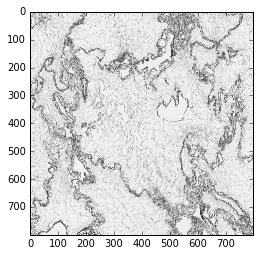

In [107]:
level = 3
imgr = scim.get_image_with_center(imsl, [22000,19000], level=level)
plt.imshow(imgr, cmap="gray")

In [108]:
level_pixelsize = imsl.level_downsamples[level] * np.asarray(pixelsize)
level_pixelsize

array([ 0.00181798,  0.00182013])

In [109]:
image_size_mm = imgr.shape * level_pixelsize
image_size_mm

array([ 1.45438018,  1.45610083])

# Localization of offset

In [110]:
offset = np.asarray((int(pm['hamamatsu.XOffsetFromSlideCentre']), int(pm['hamamatsu.YOffsetFromSlideCentre'])))
offset


array([7164983,  671863])

In [111]:

offset_mm = offset * 0.000001
offset_mm

array([ 7.164983,  0.671863])

In [112]:
offset_from_center_px = offset_mm / pixelsize
offset_from_center_px

array([ 31529.5076915,   2953.0394439])

In [113]:
im_center_px = np.asarray(imsl.dimensions) / 2.
im_center_px


array([ 45056.,  24960.])

In [114]:
offset_px = im_center_px - offset_from_center_px 
offset_px

array([ 13526.4923085,  22006.9605561])

In [115]:
offset_px.astype(np.int)

array([13526, 22006])

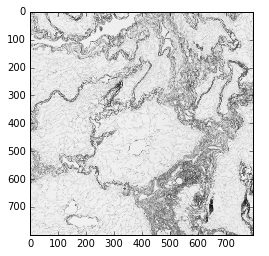

In [121]:
imgr = scim.get_image_with_center(imsl, offset_px.astype(np.int), level=3)
plt.imshow(imgr, cmap="gray")

# Draw into image

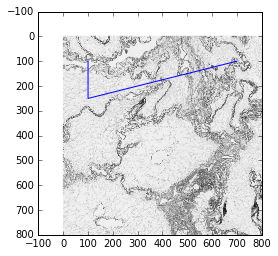

In [120]:
imgr = scim.get_image_with_center(imsl, offset_px.astype(np.int), level=3)
plt.imshow(imgr, cmap="gray")
plt.plot([100, 100, 700], [100, 250,100])

In [154]:
def get_offset_px(imsl): 
    
    offset = np.asarray((int(pm['hamamatsu.XOffsetFromSlideCentre']), int(pm['hamamatsu.YOffsetFromSlideCentre'])))
    offset_mm = offset * 0.000001
    offset_from_center_px = offset_mm / pixelsize
    im_center_px = np.asarray(imsl.dimensions) / 2.
    offset_px = im_center_px - offset_from_center_px 
    return offset_px

In [146]:
def to_px(imsl, annotation)
    offset_px = get_offset_px(imsl)
    x_nm = np.asarray(annotation[0]['x'])
    y_nm = np.asarray(annotation[0]['y'])
    x_mm = x_nm * 0.000001
    y_mm = y_nm * 0.000001
    x_px = x_mm / pixelsize[0] + offset_px[0]
    y_px = y_mm / pixelsize[1] + offset_px[1]

    pt_px= np.asarray([x_px[0], y_px[0]])
pt_px

array([ 37786.787647 ,  21901.1129415])

In [156]:
def adjust_to_image_view(imsl, x_px, y_px, level, size):
    
    x_px_view = ((x_px - annotation_center[0]) / imsl.level_downsamples[level]) + (size[0] / 2)
    y_px_view = ((y_px - annotation_center[1]) / imsl.level_downsamples[level]) + (size[1] / 2)
    return x_px_view, y_px_view

In [147]:
annotation_center = np.array([np.mean(x_px), np.mean(y_px)]) 
im_size = np.array([400, 400])


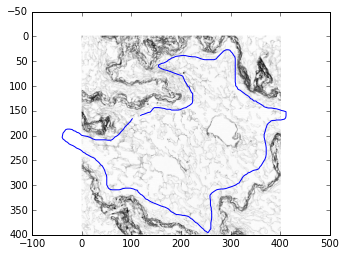

In [160]:

imgr = scim.get_image_with_center(imsl, annotation_center.astype(np.int), level=level, size=im_size)
plt.imshow(imgr, cmap="gray")
plt.plot(
    ((x_px - annotation_center[0]) / imsl.level_downsamples[level]) + (im_size[0] / 2),
    ((y_px - annotation_center[1]) / imsl.level_downsamples[level]) + (im_size[1] / 2),
)

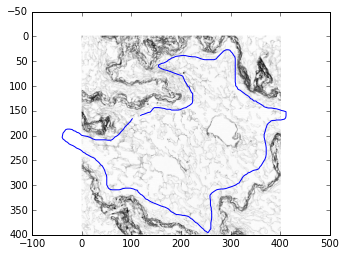

In [161]:

imgr = scim.get_image_with_center(imsl, annotation_center.astype(np.int), level=level, size=im_size)
plt.imshow(imgr, cmap="gray")
plt.plot(
    *adjust_to_image_view(imsl, x_px, y_px, level=level, size=im_size)
)

In [139]:
imsl.dimensions * np.array(pixelsize)

array([ 20.47767299,  11.35758651])

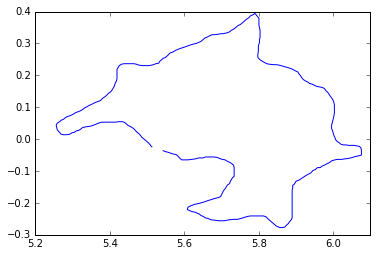

In [135]:
plt.plot(x_mm, y_mm)

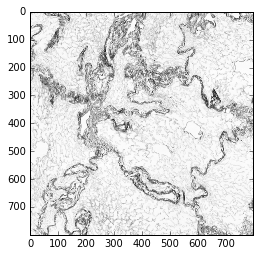

In [134]:
imgr = scim.get_image_with_center(imsl, pt_px.astype(np.int) + offset_px, level=3)
plt.imshow(imgr, cmap="gray")